In [1]:
## Path for modules

import sys,os

import numpy as np
import xarray as xr

from netCDF4 import Dataset

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import numpy.ma as ma

import matplotlib.cm as mplcm
import matplotlib.colors as colors
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import date, datetime
from xhistogram.xarray import histogram

%matplotlib inline

In [12]:
## Dataset : grid files and one example of U and V for test

dirgrid='/mnt/meom/workdir/alberta/eNATL60/eNATL60-I/'
gridfile=dirgrid+'mesh_hgr_eNATL60ACO_3.6.nc'
dsgrid=xr.open_dataset(gridfile,chunks={'x':500,'y':500})

e1u=dsgrid.e1u
e1v=dsgrid.e1v
e2u=dsgrid.e2u
e2v=dsgrid.e2v
ff=dsgrid.ff

dirvar='/mnt/meom/workdir/alberta/eNATL60/eNATL60-BLBT02-S/1h/ACO/'
ufile=dirvar+'eNATL60ACO-BLBT02_y2009m12d12.1h_sozocrtx.nc'
vfile=dirvar+'eNATL60ACO-BLBT02_y2009m12d12.1h_somecrty.nc'
dsu=xr.open_dataset(ufile,chunks={'x':500,'y':500})
dsv=xr.open_dataset(vfile,chunks={'x':500,'y':500})
u=dsu.sozocrtx[0]
v=dsv.somecrty[0]
lon=dsu.nav_lon
lat=dsu.nav_lat

In [24]:
def curl(u,v,e1v,e2u,ff):
    '''
    This routine computes the relative vorticity from 2D fields of horizontal velocities and the spatial Coriolis parameter.
    '''
    #Computation of dy(u)
    fe2u=1/e2u
    fse2u=fe2u.squeeze()
    dyu=(u.shift(y=-1) - u)*fse2u
    #Computation of dx(v)
    fe1v=1/e1v
    fse1v=fe1v.squeeze()
    dxv=(v.shift(x=-1) - v)*fse1v
    #Projection on the grid T
    dxvt=0.5*(dxv.shift(y=-1)+dxv)
    dyut=0.5*(dyu.shift(x=-1)+dyu)
    #Computation of the vorticity divided by f
    fff=1/ff
    curl=(dxvt-dyut)*fff
    return curl

In [4]:
def strain(u,v,e1u,e1v,e2u,e2v,ff):
    '''
    This routine computes the relative vorticity from 2D fields of horizontal velocities and the spatial Coriolis parameter.
    '''
    #Computation of dy(u)
    fe2u=1/e2u
    fse2u=fe2u.squeeze()
    dyu=(u.shift(y=-1) - u)*fse2u
    #Computation of dx(v)
    fe1v=1/e1v
    fse1v=fe1v.squeeze()
    dxv=(v.shift(x=-1) - v)*fse1v
    #Computation of dy(v)
    fe2v=1/e2v
    fse2v=fe2v.squeeze()
    dyv=(v.shift(y=-1) - v)*fse2v
    #Computation of dx(u)
    fe1u=1/e1u
    fse1u=fe1u.squeeze()
    dxu=(u.shift(x=-1) - u)*fse1u
    #Projection on the grid T
    dxvt=0.5*(dxv.shift(y=-1)+dxv)
    dyut=0.5*(dyu.shift(x=-1)+dyu)
    dxut=0.5*(dxu.shift(x=-1)+dxu)
    dyvt=0.5*(dyv.shift(y=-1)+dyv)
    #Computation of the strain divided by f
    fff=1/ff
    strain=np.sqrt( (dyut+dxvt)*(dyut+dxvt) + (dxut-dyvt)*(dxut-dyvt) ) *fff
    return strain

In [25]:
#Compute curl and strain with python

curl_python=curl(u,v,e1v,e2u,ff)
strain_python=strain(u,v,e1u,e1v,e2u,e2v,ff)

In [6]:
#Compute curl and strain from cdftools
meshfile=dirgrid+'mesh_hgr_eNATL60ACO_3.6.nc'
dsgrid=xr.open_dataset(gridfile,chunks={'x':500,'y':500})

filecurl=dirvar+'eNATL60ACO-BLBT02_y2009m12d12.1h_socurloverf.nc'
if not os.path.exists(filecurl):
    print('Computing '+str(filecurl))
    !ln -sf $gridfile mesh_hgr.nc
    !cdfcurl -u $ufile sozocrtx -v $vfile somecrty -overf -surf -l 1 -o $filecurl -nc4
    !rm mesh*

dscurl=xr.open_dataset(filecurl,chunks={'x':500,'y':500})
curl_cdf=dscurl.socurloverf[0]

filestrain=dirvar+'eNATL60ACO-BLBT02_y2009m12d12.1h_sostrainoverf.nc'
if not os.path.exists(filestrain):
    print('Computing '+str(filestrain))
    !ln -sf $gridfile mesh_hgr.nc
    !/mnt/meom/workdir/alberta2/DEV/CDFTOOLS/bin/cdfstrain -u $ufile sozocrtx -v $vfile somecrty -overf -surf -l 1 -o $filestrain -nc4
    !rm mesh*
dsstrain=xr.open_dataset(filestrain,chunks={'x':500,'y':500})
strain_cdf=dsstrain.sostrainoverf[0]


In [22]:
def plot_surf(data1,data2,vmin,vmax,var_title_data1,var_title_data2,cmap):
    fig = plt.figure(figsize=(14,20))
    gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[2]) 
    
    
    ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())#221
    ax2 = fig.add_subplot(gs[0, 1],projection=ccrs.PlateCarree())#222
    
    # Adjust subplots
    plt.subplots_adjust(hspace=0.0,wspace=0.1)
    
    norm_fld_data1 = colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
    
    pcolor1 = ax1.pcolormesh(lon,lat,data1,cmap=cmap,vmin=vmin,vmax=vmax,norm = norm_fld_data1)
    pcolor2 = ax2.pcolormesh(lon,lat,data2,cmap=cmap,vmin=vmin,vmax=vmax,norm = norm_fld_data1)
    
    # Add the Azores
    land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor='dimgray')
    ax1.add_feature(land)
    ax2.add_feature(land)
    
    
    # Colorbar ax1
    cax1,kw1   = mpl.colorbar.make_axes(ax1,location='bottom',pad=0.05,shrink=0.95)
    out1       = fig.colorbar(pcolor1,cax=cax1,extend='both',**kw1)
    out1.set_label(var_title_data1,size=16)
    out1.ax.tick_params(labelsize=16)
    xticks_ax1 = np.linspace(vmin,vmax,num=5)
    out1.set_ticks(xticks_ax1)
    
    # Colorbar ax2
    cax2,kw2   = mpl.colorbar.make_axes(ax2,location='bottom',pad=0.05,shrink=0.95)
    out2       = fig.colorbar(pcolor1,cax=cax2,extend='max',**kw2)
    out2.set_label(var_title_data2,size=16)
    out2.ax.tick_params(labelsize=16)
    xticks_ax2 = np.linspace(vmin,vmax,num=5)
    out2.set_ticks(xticks_ax2)
    
    # Grid    
    gl1            = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,lw=1,color='gray',alpha=0.8, ls='--')
    gl1.xformatter = LONGITUDE_FORMATTER
    gl1.yformatter = LATITUDE_FORMATTER
    gl1.xlabel_style = {'size': 13, 'color': 'dimgray'}
    gl1.ylabel_style = {'size': 13, 'color': 'dimgray'}
    gl1.xlabels_top = False
    gl1.ylabels_right = False
    gl2            = ax2.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,lw=1,color='gray',alpha=0.8, ls='--')
    gl2.xformatter = LONGITUDE_FORMATTER
    gl2.yformatter = LATITUDE_FORMATTER
    gl2.xlabel_style = {'size': 13, 'color': 'dimgray'}
    gl2.ylabel_style = {'size': 13, 'color': 'dimgray'}
    gl2.xlabels_top = False
    gl2.ylabels_right = False
    gl2.ylabels_left = False
    
    # Adjusting axes
    ax1.set_xlim((-36, -26))
    ax1.set_ylim((25, 40))
    ax2.set_xlim((-36, -26))
    ax2.set_ylim((25, 40))


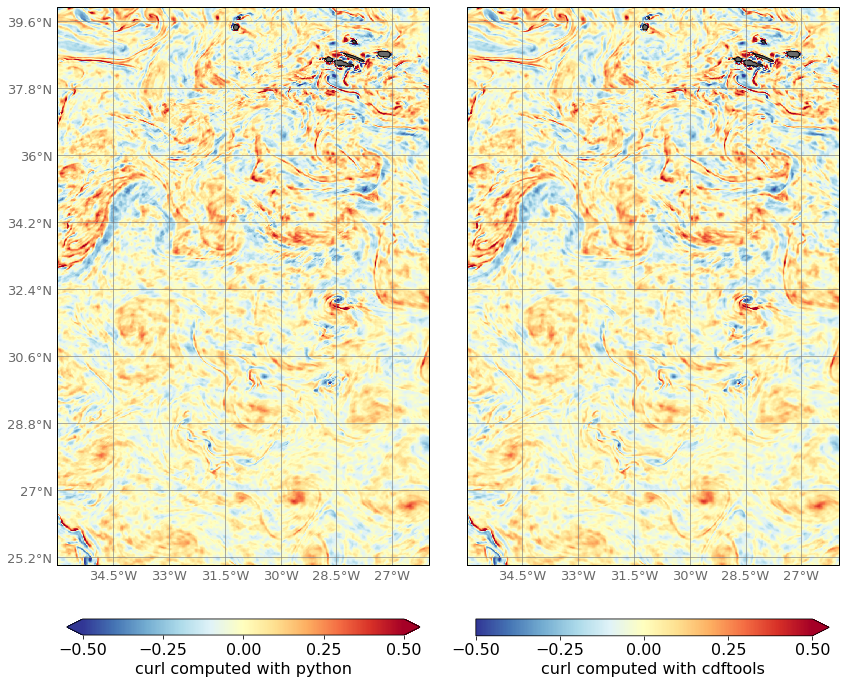

In [26]:
plot_surf(curl_python.squeeze(),curl_cdf,-0.5,0.5,'curl computed with python','curl computed with cdftools','RdYlBu_r')

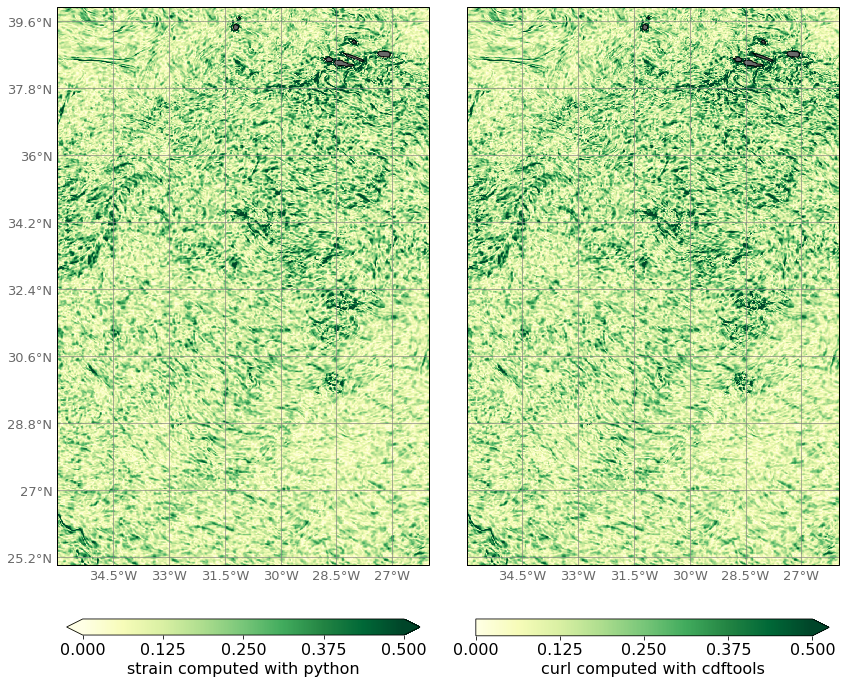

In [27]:
plot_surf(strain_python.squeeze(),strain_cdf,0,0.5,'strain computed with python','curl computed with cdftools','YlGn')